In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install evaluate peft==0.10.0 transformers==4.36.0 accelerate==0.28.0

import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import CIFAR10
from transformers import AutoImageProcessor
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.targets):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = ViTForImageClassification.from_pretrained(
        pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = CIFAR10(root="./data", train=True, download=True)
test_dataset = CIFAR10(root="./data", train=False, download=True)

classes = train_dataset.classes
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/DeeplearningAdv/HW2-2_ViTModel",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7,
    report_to="none"
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

Epoch,Training Loss,Validation Loss,F1
1,0.730900,0.662803,0.958939
2,0.367600,0.375806,0.970016
3,0.272000,0.316857,0.967959


TrainOutput(global_step=1875, training_loss=0.6864678405761718, metrics={'train_runtime': 1089.3442, 'train_samples_per_second': 27.54, 'train_steps_per_second': 1.721, 'total_flos': 2.32492637712384e+18, 'train_loss': 0.6864678405761718, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 3.1060545 , -0.5542131 ,  0.03267741, ..., -0.42189944,
        -0.26534215, -0.4473495 ],
       [ 2.8499885 , -0.53790283,  0.38648987, ..., -0.29257798,
        -0.41742128, -0.59258616],
       [ 2.9544353 , -0.5001608 ,  0.14039205, ..., -0.4898048 ,
        -0.33649006, -0.45050097],
       ...,
       [-0.50057757,  0.0191983 , -0.3948545 , ..., -0.1415959 ,
        -0.18479063,  3.153633  ],
       [-0.37357032,  0.02918863, -0.42534828, ..., -0.18696898,
        -0.3035211 ,  3.0226495 ],
       [-0.44143   , -0.32555744,  0.09873236, ...,  0.2003504 ,
        -0.6192968 ,  1.8665252 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

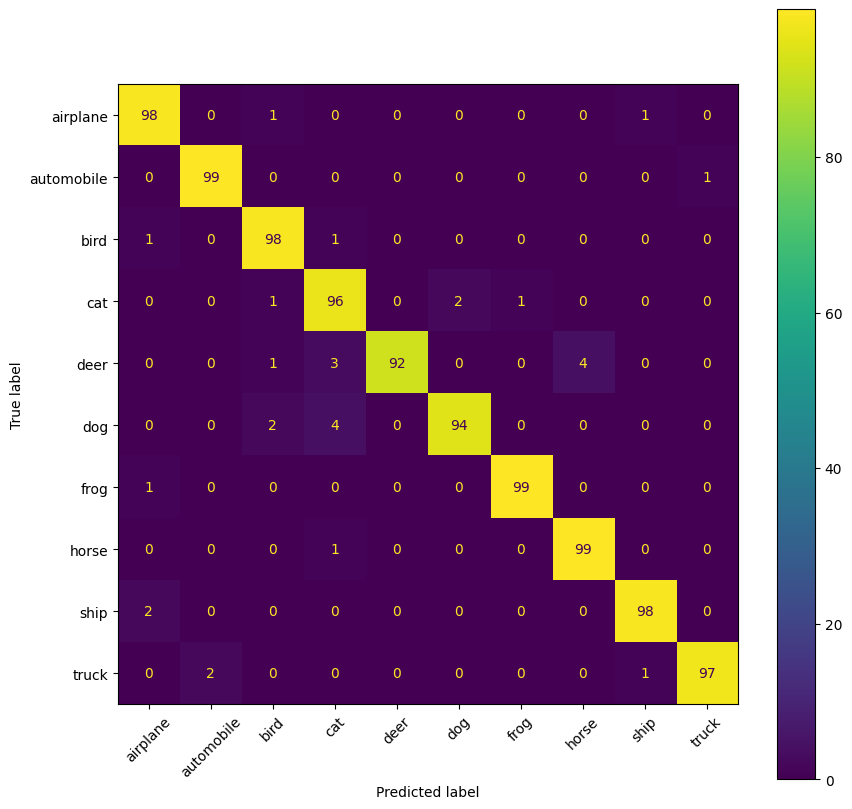

In [9]:
report_to="none"
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()